In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
from scipy import stats
import warnings
warnings.filterwarnings("ignore") 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.weight"] = "bold"


In [2]:
file1 = xr.open_dataset("/public/home/songqh/my_data/ECCO2/Qsw/oceQsw.2022.nc")
file2 = xr.open_dataset("/public/home/songqh/my_data/ECCO2/Qnet/oceQnet.2022.nc")
file3 = xr.open_dataset("/public/home/songqh/my_data/SST/oisst.2022_box.nc")
file4 = xr.open_dataset("/public/home/songqh/my_data/ECCO2/MXLDEPTH/MXLDEPTH.2022.nc")
file5 = xr.open_dataset("/public/home/songqh/my_data/ECCO2/Theta/THETA_interp/THETA.2022_box.nc")
file6 = xr.open_dataset("/public/home/songqh/my_data/ECCO2/UVEL/UVEL_interp/uvel_all_interp.nc")
file7 = xr.open_dataset("/public/home/songqh/my_data/ECCO2/VVEL/VVEL_interp/vvel_all_interp.nc")
file8 = xr.open_dataset("/public/home/songqh/my_data/ECCO2/WVEL/WVEL_interp/wvel_all_interp.nc")
sw = file1['oceQsw'].loc['2022-06-02T12:00:00.000000000':'2022-08-31T12:00:00.000000000',50:60,140:175].mean(('LATITUDE_T','LONGITUDE_T'))
Q = file2['oceQnet'].loc['2022-06-02T12:00:00.000000000':'2022-08-31T12:00:00.000000000',50:60,140:175].mean(('LATITUDE_T','LONGITUDE_T'))
sst = file3['sst'].loc['2022-06-01T00:00:00.000000000':'2022-08-31T00:00:00.000000000',50:60,140:175].mean(('lat','lon'))
depth = file4['MXLDEPTH'].loc['2022-06-01T12:00:00.000000000':'2022-08-31T12:00:00.000000000',50:60,140:175].mean(('LATITUDE_T','LONGITUDE_T'))
theta = file5['THETA'].loc['2022-06-02T12:00:00.000000000':'2022-08-31T12:00:00.000000000',5:25,45:65,135:180].values
uwnd = file6['UVEL'].loc['2022-06-02T12:00:00.000000000':'2022-08-31T12:00:00.000000000',5:15,45:65,135:180].values.mean((1))
vwnd = file7['VVEL'].loc['2022-06-02T12:00:00.000000000':'2022-08-31T12:00:00.000000000',5:15,45:65,135:180].values.mean((1))
wwnd = file8['WVEL'].loc['2022-06-02T12:00:00.000000000':'2022-08-31T12:00:00.000000000',15:25,45:65,135:180].values.mean((1))
lon = file5['LONGITUDE_T'].loc[135:180].values
lat = file5['LATITUDE_T'].loc[45:65].values
temadvect = np.zeros((91,80,180))
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
for i in range(91):
    temadvect[i,:,:] = mpcalc.advection(theta[i,0:2].squeeze().mean(0), uwnd[i], vwnd[i],dx=dx, dy=dy,x_dim=-1, y_dim=-2)
convect_all = ((theta[:,2,:,:] - theta[:,1,:,:]))/10 * wwnd 
differences = []
for i in range(1, len(sst)):
    diff = sst[i] - sst[i-1]
    differences.append(diff)
dTdt = np.array(differences)
q_heat = Q*24*3600 / 1030 / 3996 / depth
sw_heat = sw*24*3600 / 1030 / 3996 / depth
advect = ( np.nanmean(temadvect[:,20:60,20:160],(1,2)))*24*3600  
convect = np.nanmean(convect_all[:,20:60,20:160],(1,2)) *24*3600
advect = np.nan_to_num(advect,nan=0)
convect = np.nan_to_num(convect,nan=0)
res = differences - q_heat - advect - convect


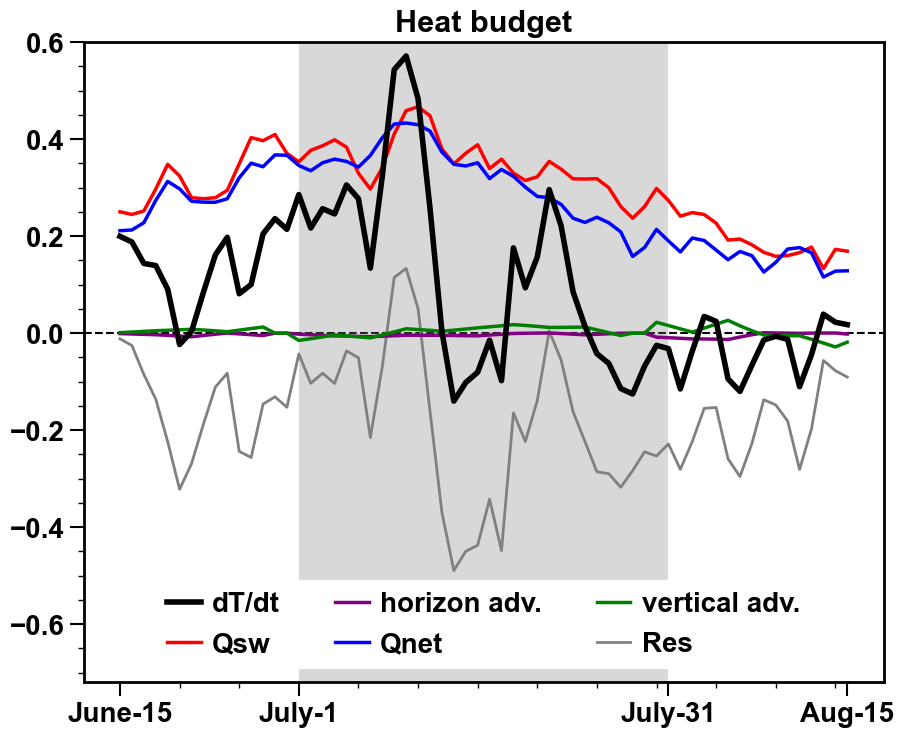

In [3]:
proj = ccrs.PlateCarree(central_longitude=145)
fig = plt.figure(figsize=(10,8))

ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
# ax1 = fig.add_subplot(325)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax1.plot(np.arange(15,77),differences[15:77],c='k',lw=4,label='dT/dt',zorder=100)
ax1.plot(np.arange(15,77),sw_heat[15:77],lw=2.5,c='r',label='Qsw')
ax1.plot(np.arange(15,77),advect[15:77],lw=2.5,c='purple',label='horizon adv.',zorder=10)

ax1.plot(np.arange(15,77),q_heat[15:77],lw=2.5,c='b',label='Qnet')
ax1.plot(np.arange(15,77),convect[15:77],lw=2.5,c='green',label='vertical adv.',zorder=10)

ax1.plot(np.arange(15,77),res[15:77],lw=2,c='gray',label='Res')
ax1.axhline(y=0, color='k', linestyle='--',lw=1.5,zorder=0)
ax1.set_ylim(-0.72,0.6)
ax1.set_xticks([15,30,61,76])
ax1.minorticks_on()
ax1.axvspan(30, 61, facecolor='gray', alpha=0.3)
ax1.set_xticklabels(['June-15','July-1','July-31','Aug-15'])
ax1.tick_params(direction='out', length=10, width=1.5, labelsize=20,axis='both', which='major')
ax1.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
ax1.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax1.set_title("Heat budget",fontsize=22,weight='bold',loc='center',pad=8)
# ax1.text(20,0.5,"R(dTdt&Qsw)=0.55, p<0.01",fontsize=20,weight='bold')
ax1.legend(fontsize=20,facecolor='w',handlelength=1.2,ncol=3,columnspacing=2,handletextpad=0.4,loc='lower center',frameon=True,edgecolor='w',framealpha=1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1,wspace=0.3,hspace=0.22) 
# fig.savefig("/public/home/songqh/project/NC_figure/figures/figure-3.jpg",dpi=600)
# fig.savefig("/public/home/songqh/project/MHW_2022/figures/figure-3.tiff",dpi=600)
plt.show()

In [4]:
corr_coeff, p_value = stats.pearsonr(differences[30:61], sw_heat[30:61])
print("Pearson相关系数：", corr_coeff)
print("p值：", p_value)


Pearson相关系数： 0.6609981674198991
p值： 5.170265267465324e-05
